# **ECON 852, Assignment 1** #
Ian Scott

04/02/2025

### **Setup** ###

In [1]:
#Set working directory, load data and libraries
setwd("/Users/ianscott/Downloads")
data <- read.csv(file = "men2015b.csv")

library(tidyverse)
library(FNN)
library(rsample)
library(sandwich)
library(lmtest)
library(ggpmisc)
library(caret)
library(effectsize)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.0     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'FNN' was built under R version 4.3.3"
Warning message:
"package 'sandwich' was built under R version 4.3.3"
Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"package 'ggpmisc' was built under R version 4.3.3"
Loading required package: ggpp

Warning message:
"package 'ggpp' was built under R version 4.3.3"
Registered S3 methods overwri

### **Question 1** ###

In [2]:
#Create the logearn variable and attach it to the dataset
data$earnings <- log(data$earnings)

#Ensure the earnings are now in log form
head(data)

,age,educ,earnings,marry
,<int>,<int>,<dbl>,<int>
1,27,2,6.579251,0
2,25,3,5.991465,0
3,55,3,7.205004,1
4,34,4,6.684612,1
5,53,5,6.856462,1
6,64,1,6.530703,1


In [3]:
# Optional: Print model details
#Use age^2 to approximate experience. The chosen models use basic interactions of the terms.
models <- list(
    model1 <- lm(formula = earnings ~ age + factor(educ) + marry, data = data), # Basic model of all variables. Given the small number of predictors included all of them seems sensible.
    model2 <- lm(formula = earnings ~ I(age^2) + age + factor(educ) + marry, data = data), # 
    model3 <- lm(formula = earnings ~ age + I(educ^2) + factor(educ) + marry, data = data), # 
    model4 <- lm(formula = earnings ~ age + educ + age*factor(educ) + marry, data = data) # Age and education could be jointly related
)

# Function to extract R-squared value
get_r2 <- function(model) {
  summary(model)$r.squared
}

# Function to extract RMSE , which indicates the accuracy of model predictions
get_rmse <- function(model) {
  residuals <- model$residuals
  sqrt(mean(residuals^2))
}

#Create a list of R^2 values
r2_values <- sapply(models, get_r2)
max_r2_index <- which.max(r2_values)
max_r2_value <- max(r2_values)

#Create a list of RMSE values
rmse_values <- sapply(models, get_rmse)
min_rmse_index <- which.min(rmse_values)
min_rmse_value <- min(rmse_values)

#Print the best model for each. This also include intuition for each model.
paste("The model with the highest explanatory power and most accurate predictions, of those tested, model ", 
  max_r2_index, 
  ". This is the best performing of linear regression models with basic and intuitive interaction terms included.",
  ifelse(max_r2_index == 1, "This basic model includes all the variables and does not interact them. It makes sense to include all the variables since there are so few predictors.",
  ifelse(max_r2_index == 2, "This model uses age and age squared to achieve a similar effect as the mincer equation.",
  ifelse(max_r2_index == 3, "This model simulates nonlinear returns to schooling from advanced education.",
  ifelse(max_r2_index == 4, "This models interacts age and education to show how education and age, as a proxy for experience, are jointly related.",
  "unknown."))))
)

[1] "The model with the highest explanatory power and most accurate predictions, of those tested, model  2 . This is the best performing of linear regression models with basic and intuitive interaction terms included. This model uses age and age squared to achieve a similar effect as the mincer equation."

### **Question 2** ###

In [4]:
## Set up the hypothetical people
# Assign the potential values of each variable.
ages <- c(30, 40, 50, 60, 70)
edlvl <- c(4, 5)
marstat <- c(0, 1)

# Turn the lists of values into a grid.
hyp_people <- expand.grid(
    age = ages,
    educ = edlvl,
    marry = marstat
)

# Add age squared to the hypothetical people, to reflect the chosen model specification. This will be used later with the KNN model.
#hyp_people$agesq <- hyp_people$age*hyp_people$age

In [5]:
# Create predictions from the model, and estimate a 99% confidence interval
predictions <- predict(model2, newdata = hyp_people, interval = "prediction", level = 0.99)
results <- cbind(hyp_people, predictions)

print(results)

   age educ marry      fit      lwr      upr
1   30    4     0 6.847432 5.343341 8.351524
2   40    4     0 7.069697 5.565585 8.573809
3   50    4     0 7.122501 5.618366 8.626637
4   60    4     0 7.005845 5.501686 8.510003
5   70    4     0 6.719728 5.215383 8.224073
6   30    5     0 7.006263 5.502064 8.510463
7   40    5     0 7.228528 5.724318 8.732738
8   50    5     0 7.281332 5.777109 8.785555
9   60    5     0 7.164676 5.660439 8.668913
10  70    5     0 6.878559 5.374144 8.382973
11  30    4     1 7.001807 5.497709 8.505905
12  40    4     1 7.224072 5.720002 8.728142
13  50    4     1 7.276876 5.772808 8.780944
14  60    4     1 7.160220 5.656132 8.664308
15  70    4     1 6.874103 5.369808 8.378397
16  30    5     1 7.160638 5.656443 8.664833
17  40    5     1 7.382903 5.878745 8.887060
18  50    5     1 7.435707 5.931562 8.939852
19  60    5     1 7.319050 5.814895 8.823206
20  70    5     1 7.032933 5.528580 8.537287


In [6]:
# Determine which row has the highest predicted wage
max_pred_row <- results[which.max(results$fit), ]

paste("The highest log earnings are predicted for someone who is", 
    max_pred_row$age, 
    "years old, who has",
    ifelse(max_pred_row$educ == 5, "a graduate degree,", 
    ifelse(max_pred_row$educ == 4, "an undergraduate degree degree,", 
    ifelse(max_pred_row$educ == 3, "a college diploma,", 
    ifelse(max_pred_row$educ == 2, "completed high school,", 
    ifelse(max_pred_row$educ ==1, "not completed high school,", 
    "Unknown"))))),
    "and is",
    ifelse(max_pred_row$marry == 0, "not married.",
    ifelse(max_pred_row$marry == 1, "married.", 
    "unknown"))
)

[1] "The highest log earnings are predicted for someone who is 50 years old, who has a graduate degree, and is married."

### **Question 3** ###

In [7]:
data$educ <- as.factor(data$educ)  # Ensure it's a factor
dummy_vars <- model.matrix(~ educ - 1, data = data)  # Remove intercept

# Convert matrix to dataframe and rename columns
dummy_df <- as.data.frame(dummy_vars)
colnames(dummy_df) <- paste0("educ", levels(data$educ))

# Add dummy variables to original dataset
data <- cbind(data, dummy_df)
data <- subset(data, select = -educ)

head(data)

,age,earnings,marry,educ1,educ2,educ3,educ4,educ5
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,27,6.579251,0,0,1,0,0,0
2,25,5.991465,0,0,0,1,0,0
3,55,7.205004,1,0,0,1,0,0
4,34,6.684612,1,0,0,0,1,0
5,53,6.856462,1,0,0,0,0,1
6,64,6.530703,1,1,0,0,0,0


In [8]:
#Transform the data so the agesq interaction term is present in the KNN model
#data$agesq <- data$age*data$age

#Using a loop to find the optimal values of K for 100 different values.
ks = c(1:100)
r_sq = c()
for (i in 1:100){
    r2pred = knn.reg(train=subset(data, select = -earnings),y=data$earnings,k=i)$R2Pred
    r_sq = c(r_sq,r2pred)
}

#Printing results
optk = ks[which.max(r_sq)]

paste("The optimal value of K, determined through leave one out cross-validation, is", 
    optk, 
    "."
)

[1] "The optimal value of K, determined through leave one out cross-validation, is 47 ."

In [9]:
# Determine differences between the lecture and assignment datasets.
paste("The cars dataset used in class has", 
    length(mtcars), 
    "characteristics, while the assignment dataset has",
    length(data), ". The cars dataset has", 
    length(unique(mtcars$mpg)), 
    "unique values of the outcome variable, and the assignment dataset has", 
    length(unique(data$earnings))
)

[1] "The cars dataset used in class has 11 characteristics, while the assignment dataset has 8 . The cars dataset has 25 unique values of the outcome variable, and the assignment dataset has 3687"

The value of K is likely larger than the ones we've seen in class for 3 reasons. The first reason is dimensionality. There are more variables in this dataset than there were in class, meaning there is more dimensionality. The KNN algorithm then needs more neighbours to find determine how each dimension affects the prediction. This reasoning bleeds into the second factor that might affect the size of K, the number of observations. Since there are more observations in this dataset there are more variations that need to be compared. This leads to a higher K, since more comparisons are needed. The third, and final, reason K is likely larger has to do with the number of unique values of K.

### **Question 4** ###

In [10]:
hyp_people$educ <- as.factor(hyp_people$educ)  # Ensure it's a factor
hp_dummy_vars <- model.matrix(~ educ - 1, data = hyp_people)  # Remove intercept

# Convert matrix to dataframe and rename columns
hp_dummy_df <- as.data.frame(hp_dummy_vars)
colnames(hp_dummy_df) <- paste0("educ", levels(hyp_people$educ))

# Add dummy variables to original dataset
hyp_people <- cbind(hyp_people, hp_dummy_df)
hyp_people <- subset(hyp_people, select = -educ)

hyp_people$educ1 <- ifelse(hyp_people$age == 0, 0, 0)
hyp_people$educ2 <- ifelse(hyp_people$age == 0, 0, 0)
hyp_people$educ3 <- ifelse(hyp_people$age == 0, 0, 0)

hyp_people <- hyp_people[c("age", "marry", "educ1", "educ2", "educ3", "educ4", "educ5")]

In [11]:
#Predict the results and store within the results dataset
knnpred <- knn.reg(train = subset(data, select = -earnings), test = hyp_people, y = data$earnings, k = optk)
knnresults <- cbind(results, knnpred$pred)

#Change the column name to be easier to interpret
colnames(knnresults)[colnames(knnresults) == "knnpred$pred"] <- "knnfit"

#Ensure previous functions have worked
print(knnresults)

   age educ marry      fit      lwr      upr   knnfit
1   30    4     0 6.847432 5.343341 8.351524 6.978770
2   40    4     0 7.069697 5.565585 8.573809 7.077622
3   50    4     0 7.122501 5.618366 8.626637 7.203708
4   60    4     0 7.005845 5.501686 8.510003 7.019249
5   70    4     0 6.719728 5.215383 8.224073 6.685774
6   30    5     0 7.006263 5.502064 8.510463 7.160729
7   40    5     0 7.228528 5.724318 8.732738 7.261842
8   50    5     0 7.281332 5.777109 8.785555 7.418289
9   60    5     0 7.164676 5.660439 8.668913 7.407101
10  70    5     0 6.878559 5.374144 8.382973 6.671844
11  30    4     1 7.001807 5.497709 8.505905 6.874753
12  40    4     1 7.224072 5.720002 8.728142 7.305552
13  50    4     1 7.276876 5.772808 8.780944 7.355282
14  60    4     1 7.160220 5.656132 8.664308 7.059127
15  70    4     1 6.874103 5.369808 8.378397 7.018851
16  30    5     1 7.160638 5.656443 8.664833 7.174683
17  40    5     1 7.382903 5.878745 8.887060 7.373569
18  50    5     1 7.435707 5

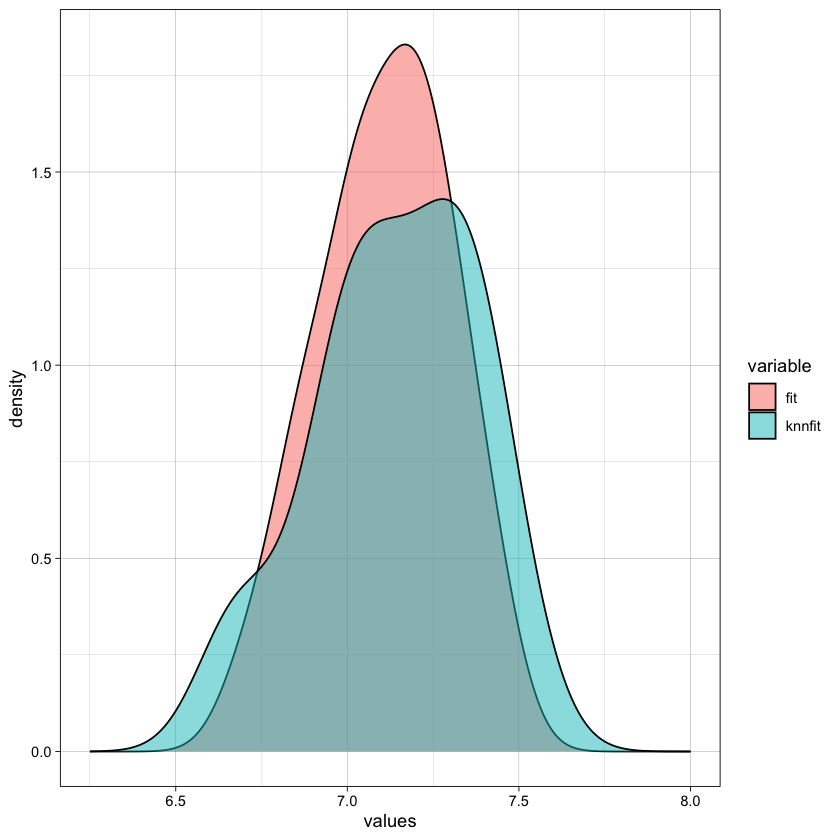

In [12]:
#Create an object to more easily plot the results
hist <- data.frame(variable = c(rep("fit", length(knnresults$age)),rep("knnfit", length(knnresults$age))), values = c(knnresults$fit, knnresults$knnfit))
hist$fit <- knnresults$fit
hist$knnfit <- knnresults$knnfit

#Plotting the results using a density chart. There is a small sample size but binning would put few values into the bins, making this a better representation of the distribution.
ggplot(hist, aes(x=values, fill=variable))+
    geom_density(alpha = 0.5) +
    theme_linedraw() +
    xlim(6.25,8)

The KNN values are skewed slightly right. While the fit values from OLS are normally distributed, the KNN values have a lower second peak on the left of the main peak. This suggests they are not normally distributed. However,this chart shows they have similar means given the relatively small range of the X axis.

### **Question 5** ###

In [13]:
#Standardizing the training data to be able to train the model. Standardization is my chosen form of rescaling.
#s_data <- standardize(subset(data, select = -earnings))

s_data <- data
s_data$age <- scale(data$age)

#s_data$agesq <- scale(data$agesq)

#Not standardizing the marriage variable

#Find optimal K using the same for loop with scaled data
ks = c(1:100)
r_sq = c()
for (i in ks){
    r2pred = knn.reg(train=subset(s_data, select = -earnings), y=data$earnings, k=i)$R2Pred
    r_sq = c(r_sq,r2pred)
}

soptk = ks[which.max(r_sq)]
paste("The optimal value of K with scaled data, determined through leave one out cross-validation, is", 
    soptk, 
    "."
)

[1] "The optimal value of K with scaled data, determined through leave one out cross-validation, is 75 ."

This is a larger value than I found in question 3. This could be because there are smaller changes between values in the scaled data. Because of this, more neighbours would be needed to explain the outcome variable. This is because more information is needed to accurately predict the results of more similar observations.

### **Question 6** ###

In [14]:
#Load in the data to be scaled, and add the necessary transformations
agemean <- mean(data$age)
agesd <- sd(data$age)
#age2mean <- mean(data$agesq)
#age2sd <- sd(data$agesq)

s_hyp_people <- hyp_people
s_hyp_people$age <- (hyp_people$age - agemean)/agesd
#s_hyp_people$agesq <- (hyp_people$agesq - age2mean)/age2sd
#s_hyp_people$educ <- (hyp_people$educ - educmean)/educsd

#Creating and printing the predicted values
s_knnpred <- knn.reg(train = subset(s_data, select = -earnings), test = s_hyp_people, y = data$earnings, k = soptk)

knnresults <- cbind(knnresults, s_knnpred$pred)
colnames(knnresults)[colnames(knnresults) == "s_knnpred$pred"] <- "s_knnfit"

#Ensure the new results have been added to the results frame
head(knnresults)

,age,educ,marry,fit,lwr,upr,knnfit,s_knnfit
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,30,4,0,6.847432,5.343341,8.351524,6.978770,6.870141
2,40,4,0,7.069697,5.565585,8.573809,7.077622,7.066356
3,50,4,0,7.122501,5.618366,8.626637,7.203708,7.170956
4,60,4,0,7.005845,5.501686,8.510003,7.019249,7.034376
5,70,4,0,6.719728,5.215383,8.224073,6.685774,6.768209
6,30,5,0,7.006263,5.502064,8.510463,7.160729,7.141022


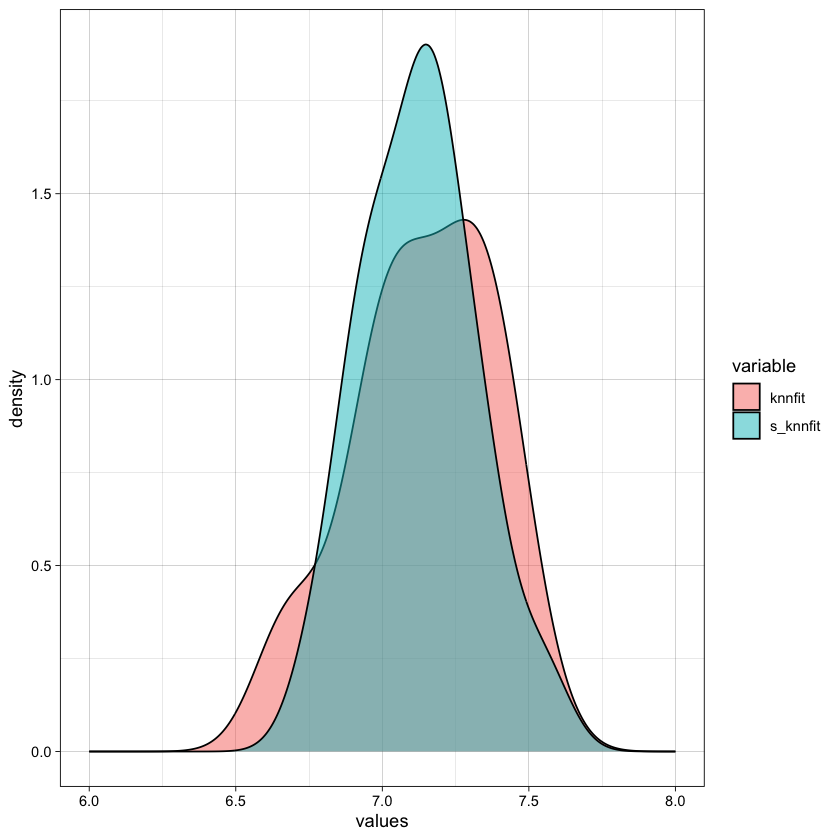

In [15]:
#Creating an object to print the values better
histo <- data.frame(variable = c(rep("knnfit", length(knnresults$age)),rep("s_knnfit", length(knnresults$age))), values = c(knnresults$knnfit, knnresults$s_knnfit))
histo$knnfit <- knnresults$knnfit
histo$s_knnfit <- knnresults$s_knnfit

#Plotting the distributions with a density plot
ggplot(histo, aes(x=values, fill=variable))+
    geom_density(alpha = 0.5) +
    theme_linedraw() +
    xlim(6, 8)

These observations are more normally distributed, and therefore much more similar to the predictions of the linear regression model.